<a href="https://colab.research.google.com/github/ryybiinana1/HW_Ml_course/blob/main/homework_8_gans_part_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [9]:
# def get_dataloader(image_size, batch_size):
#   """
#   Builds dataloader for training data.
#   Use tt.Compose and tt.Resize for transformations
#   :param image_size: height and wdith of the image
#   :param batch_size: batch_size of the dataloader
#   :returns: DataLoader object
#   """
#   transform = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     tt.CenterCrop(image_size),
#     transforms.ToTensor(),
#     tt.Normalize([0.5]*3, [0.5]*3)
#   ])

#   dataset = datasets.ImageFolder(root="/content/drive/MyDrive/datasets/faces_dataset_small", transform=transform)
#   dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
#   return dataloader

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os

image_size = 64
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, "*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = FlatImageDataset("/content/drive/MyDrive/datasets/faces_dataset_small", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


Выведем картинку из импортированного датасета

In [10]:
images, _ = next(iter(dataloader))
images = images.to(device)
print(images.shape)

torch.Size([32, 3, 64, 64])


In [11]:
# Выведем батч картинок из датасета
stats = [0.5]*3, [0.5]*3

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

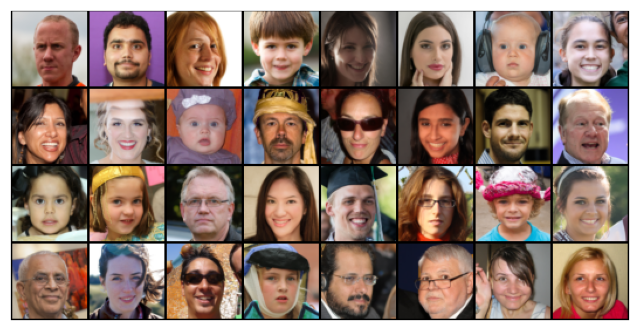

In [12]:
show_batch(dataloader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

#### **WGAN**

 **WGAN** (Wasserstein GAN) улучшает стабильность классического GAN, заменяя функцию потерь: использует **Wasserstein distance** вместо  BCE (binary cross-entropy)

Также отличие в том, что дискриминатор становится критиком, который не классифицирует real / fake, а выдает оценку "реалистичности".


In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten())

In [14]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

   nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),  # 64x64
    nn.Tanh()
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [17]:
lr = 0.0002
epochs = 40

model = {
    "discriminator": discriminator,
    "generator": generator
}


In [18]:
def gradient_penalty(D, real, fake):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real.device)
    interpolated = epsilon * real + (1 - epsilon) * fake
    interpolated.requires_grad_(True)

    d_interpolated = D(interpolated)
    grads = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(batch_size, -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return gp


In [19]:
def fit(model, epochs, train_dl, lr, start_idx=1, lambda_gp=10):
    # Переводим модели в режим обучения
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=lr * 0.5, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(), lr=lr, betas=(0.5, 0.999))
    }

    # В WGAN критик обучается чаще, чем генератор. В нашем случае 4:1
    n_critic = 2
    losses_g, losses_d, real_scores, fake_scores = [], [], [], []

    for epoch in range(epochs):
        loss_d_per_epoch, loss_g_per_epoch = [], []
        real_score_per_epoch, fake_score_per_epoch = [], []

        for i, (real_images, _) in enumerate(tqdm(train_dl)):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            for _ in range(n_critic):
                optimizer["discriminator"].zero_grad()

                # Генерируем фейковые изображения
                latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = model["generator"](latent).detach()

                # Получаем оценки реалистичности на реальных и фуйковых данных
                real_preds = model["discriminator"](real_images)
                fake_preds = model["discriminator"](fake_images)

                gp = gradient_penalty(model["discriminator"], real_images, fake_images)
                loss_d = -real_preds.mean() + fake_preds.mean() + lambda_gp * gp

                loss_d.backward()
                optimizer["discriminator"].step()

                real_score_per_epoch.append(real_preds.mean().item())
                fake_score_per_epoch.append(fake_preds.mean().item())
                loss_d_per_epoch.append(loss_d.item())

            optimizer["generator"].zero_grad()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            preds = model["discriminator"](fake_images)
            loss_g = -preds.mean()

            loss_g.backward()
            optimizer["generator"].step()

            loss_g_per_epoch.append(loss_g.item())
        # Сохраняем средние значения лоссов и оценок реалистичности за эпоху
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"loss_g: {losses_g[-1]:.4f}, "
              f"loss_d: {losses_d[-1]:.4f}, "
              f"real_score: {real_scores[-1]:.4f}, "
              f"fake_score: {fake_scores[-1]:.4f}")


    return losses_g, losses_d, real_scores, fake_scores


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model["discriminator"] = model["discriminator"].to(device)
model["generator"] = model["generator"].to(device)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [21]:
history = fit(model, epochs, dataloader, lr)

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 30.1172, loss_d: -30.4132, real_score: 20.7379, fake_score: -23.3536


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 2.8968, loss_d: -5.3177, real_score: 6.4097, fake_score: 0.1699


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 10.2521, loss_d: -2.8622, real_score: -4.1934, fake_score: -7.9155


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 4.5758, loss_d: -2.1337, real_score: 1.9169, fake_score: -0.6918


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 5.9182, loss_d: -2.4433, real_score: -0.1926, fake_score: -3.1510


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 9.3736, loss_d: -4.5780, real_score: -1.2413, fake_score: -6.5298


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 0.5593, loss_d: -5.0155, real_score: 7.7303, fake_score: 2.1895


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 6.0254, loss_d: -4.7562, real_score: 2.0765, fake_score: -3.4153


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 0.9275, loss_d: -4.0615, real_score: 5.0606, fake_score: 0.4886


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 5.2445, loss_d: -6.0222, real_score: 5.6557, fake_score: -1.3715


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 1.5752, loss_d: -5.9548, real_score: 7.5692, fake_score: 0.8352


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 3.3147, loss_d: -7.7450, real_score: 8.6903, fake_score: -0.3006


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 6.5611, loss_d: -5.7261, real_score: 2.1581, fake_score: -4.6497


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 1.7755, loss_d: -4.9352, real_score: 6.6554, fake_score: 1.0438


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 2.3088, loss_d: -4.1780, real_score: 4.5107, fake_score: -0.1579


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [16/40], loss_g: -1.3620, loss_d: -5.7724, real_score: 9.8912, fake_score: 3.1584


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 6.5193, loss_d: -4.6264, real_score: 0.5989, fake_score: -4.5606


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [18/40], loss_g: -0.9348, loss_d: -5.0264, real_score: 8.5312, fake_score: 2.7571


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.1977, loss_d: -4.9005, real_score: 3.5161, fake_score: -2.0148


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 3.0303, loss_d: -4.9275, real_score: 4.4959, fake_score: -1.1481


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 2.2187, loss_d: -4.1734, real_score: 4.2406, fake_score: -0.4303


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 3.2149, loss_d: -5.0133, real_score: 3.8317, fake_score: -1.7655


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 1.7938, loss_d: -4.5619, real_score: 4.9809, fake_score: -0.1165


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 0.1974, loss_d: -4.5090, real_score: 6.1177, fake_score: 1.1217


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 3.3210, loss_d: -6.2998, real_score: 5.1975, fake_score: -1.9188


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.5849, loss_d: -5.7012, real_score: 5.2287, fake_score: -1.2857


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 2.5302, loss_d: -6.4062, real_score: 5.9828, fake_score: -1.2054


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 0.6931, loss_d: -7.3541, real_score: 10.1590, fake_score: 1.5840


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 1.9885, loss_d: -7.0284, real_score: 7.5060, fake_score: -0.4667


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 2.8772, loss_d: -6.9054, real_score: 6.4584, fake_score: -1.3611


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [31/40], loss_g: -0.7199, loss_d: -5.7728, real_score: 9.1275, fake_score: 2.5779


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.1070, loss_d: -5.3452, real_score: 3.1209, fake_score: -2.9710


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 0.9252, loss_d: -5.7017, real_score: 6.7785, fake_score: 0.3390


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 1.0965, loss_d: -5.6425, real_score: 7.7188, fake_score: 1.3718


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.2365, loss_d: -5.3391, real_score: 3.2611, fake_score: -2.8062


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 0.3020, loss_d: -5.3353, real_score: 6.3227, fake_score: 0.4462


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 3.9382, loss_d: -5.8997, real_score: 4.4014, fake_score: -2.2113


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 2.7667, loss_d: -5.1198, real_score: 3.5552, fake_score: -2.1892


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 0.7793, loss_d: -5.9345, real_score: 6.8986, fake_score: 0.3185


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 1.2017, loss_d: -5.5097, real_score: 6.2070, fake_score: -0.0529


In [22]:
losses_g, losses_d, real_scores, fake_scores = history

Выведем батч сгенерированных картинок

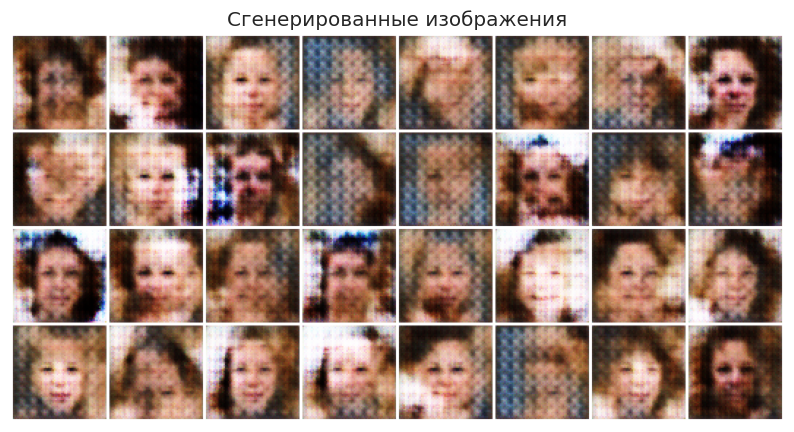

In [23]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

model["generator"].eval()

num_images = 32
latent = torch.randn(num_images, latent_size, 1, 1, device=device)

with torch.no_grad():
    fake_images = model["generator"](latent).detach().cpu()

grid = vutils.make_grid(fake_images, nrow=8, normalize=True, pad_value=1)

# Отображаем
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Сгенерированные изображения")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()


**Почему результат такого плохого качества?**
Для получения хорошего четкого результата GANы требуют большее кол-во эпох(50-200). К сожалению, вычислительные мощности google collab не позволяют мне обучить так много эпох

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

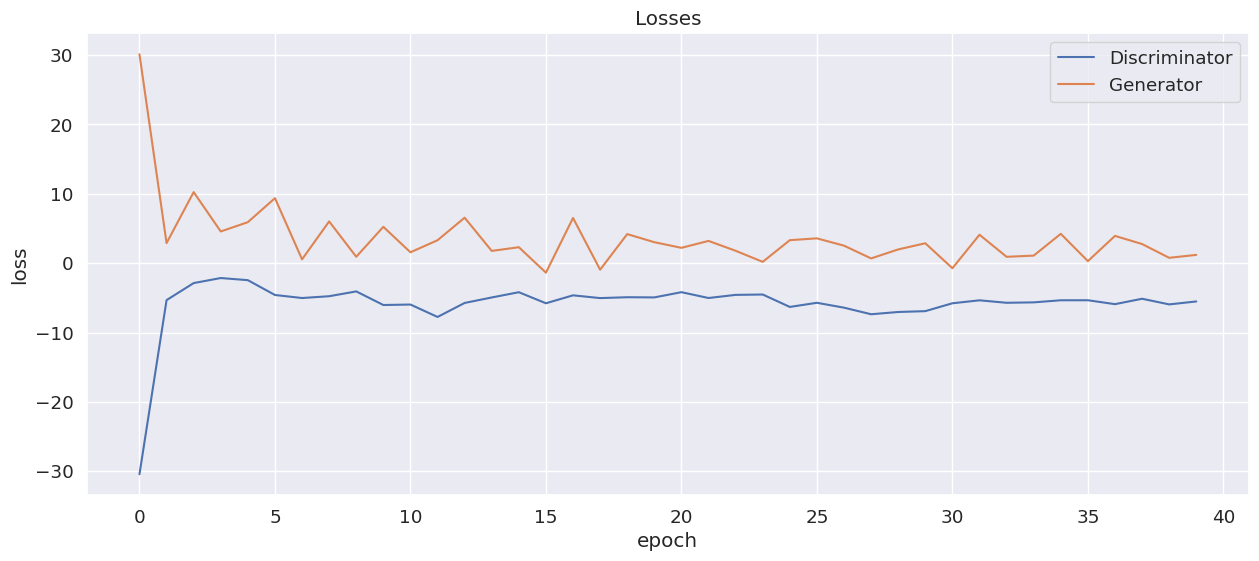

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

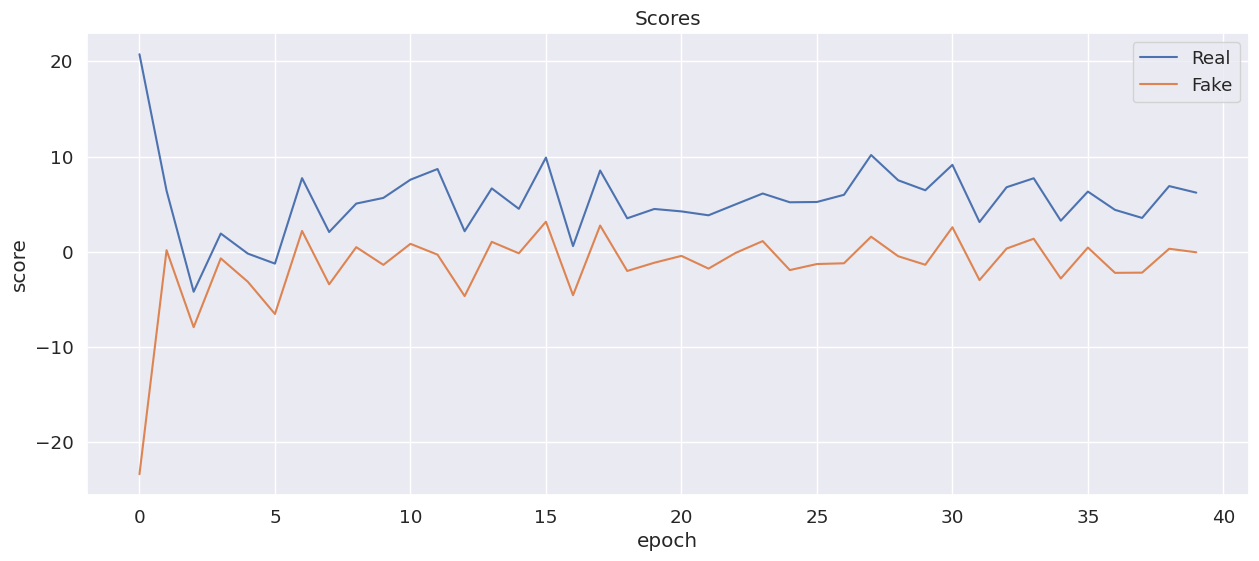

In [25]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [26]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

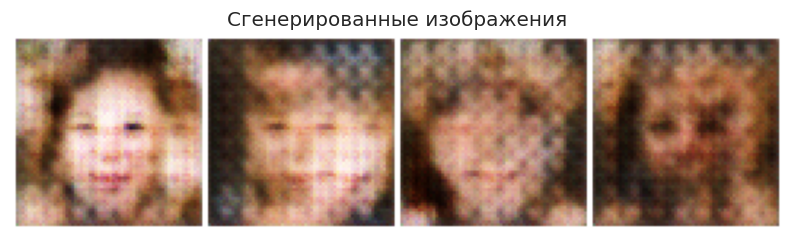

In [27]:

with torch.no_grad():
    fake_images = model["generator"](fixed_latent).detach().cpu()

grid = vutils.make_grid(fake_images, nrow=8, normalize=True, pad_value=1)

# Отображаем
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Сгенерированные изображения")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()


Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [29]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm



# Шаг 1: Подготовка моделей и трансформаций
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Сбор фейковых и реальных изображений
N = 100  # количество изображений для каждого класса

real_images = []
for images, _ in dataloader:
    real_images.append(images)
    if sum(x.size(0) for x in real_images) >= N:
        break
real_images = torch.cat(real_images, dim=0)[:N]

latent = torch.randn(N, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model["generator"](latent).cpu()

# Извлечение признаков через ResNet
def extract_features(images_tensor):
    features = []
    with torch.no_grad():
        for img in tqdm(images_tensor):
            img = transform(img).unsqueeze(0).to(device)
            feat = feature_extractor(img).squeeze().cpu().numpy()
            features.append(feat)
    return np.stack(features)

X_real = extract_features(real_images)
X_fake = extract_features(fake_images)

# Сбор данных и меток
X_all = np.vstack([X_real, X_fake])
y_all = np.array([1] * len(X_real) + [0] * len(X_fake))

# Leave-One-Out + 1NN
loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

correct = 0
for train_idx, test_idx in tqdm(loo.split(X_all)):
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    correct += int(pred == y_test)

accuracy = correct / len(X_all)
print(f"Leave-One-Out 1NN Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 172.48it/s]
0it [00:00, ?it/s]<ipython-input-29-2cc15b3b7882>:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  correct += int(pred == y_test)
<ipython-input-29-2cc15b3b7882>:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

Leave-One-Out 1NN Accuracy: 0.9900


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**Вывод:**
Accuracy > 0.5  => генератор создаёт легко различимые изображения.

В случае, когда Accuracy < 0.5  => генератор слишком похож на настоящие (или наоборот, классификатор путается)

Следовательно, наилучший результат - accuracy приближенный или меньше 0.5

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 100/100 [00:00<00:00, 119.69it/s]


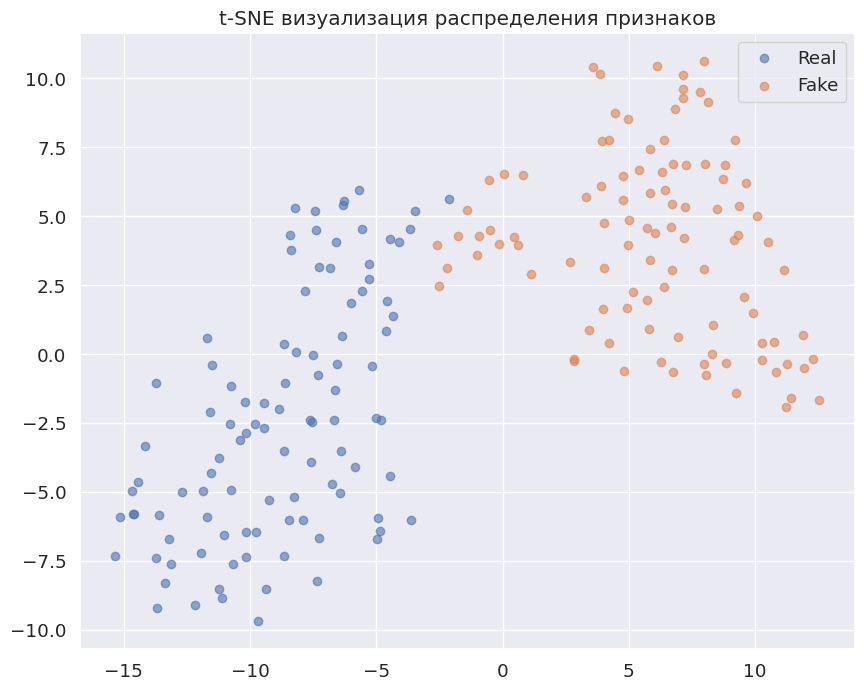

In [30]:
import torch
import numpy as np
from torchvision import models, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

resnet = models.resnet18(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])  # (512,)
feature_extractor.eval().to(device)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def extract_features(image_batch):
    features = []
    with torch.no_grad():
        for img in tqdm(image_batch):
            x = transform(img).unsqueeze(0).to(device)
            feat = feature_extractor(x).squeeze().cpu().numpy()
            features.append(feat)
    return np.stack(features)


X_real = extract_features(real_images)
X_fake = extract_features(fake_images)

X_all = np.vstack([X_real, X_fake])
y_all = np.array([1]*len(X_real) + [0]*len(X_fake))

# Применяем TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(X_all)

# Рисуем
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[y_all==1, 0], X_embedded[y_all==1, 1], label='Real', alpha=0.6)
plt.scatter(X_embedded[y_all==0, 0], X_embedded[y_all==0, 1], label='Fake', alpha=0.6)
plt.title("t-SNE визуализация распределения признаков")
plt.legend()
plt.grid(True)
plt.show()


Прокомментируйте получившийся результат:

Признаки хорошо разделимы:
Такое поведение говорит о том, что генератор всё ещё не научился имитировать реальную структуру латентного пространства, по крайней мере в глазах feature

Для более хороших результатов следует запускать больше эпох, так как WGAN-GP более сложная модель по сравнению с обычным GAN